In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from network_handler import Network_Handler
from network import Network
from person import Person
from disease_propagator import Disease_Propagator
%load_ext autoreload
%autoreload 2

In [14]:
# Parameters
## General simulation
number_of_simulations = 1
time_limit = 500

## Network-related
population_size = 1000
average_degree = 5 #Number of initial connections #Distribution
random_edge_probability = 0.1
maximum_contact_number = 2

#unit_time = population_size # number of simulation steps that make up one time step

## Disease-related
time_until_quarantine = {
    'mean': 4+3,
    'std_dev': 2
}
time_until_recovery = 14
p = 0.1 # Factor for probability to become infected in public
I_0 = int(population_size * 0.05) # Starting population of infectious individuals

## Scenario-related
number_of_daily_contacts_normal = 15
contact_reduction_factor = 5
number_of_daily_contacts_social_distancing = int(number_of_daily_contacts_normal / contact_reduction_factor)

Create our networks, first we create a base network, than the random reduction case and finally the triadic strategy case.

In [15]:
population_IDs = range(population_size)

# Network
# Degrees ranging from 3 to 10
# Clustering coefficient: between 0.15 and 0.2 
# Average shortest path length around 6
# -> Typical for social networks [Networks: An Introduction by Newman, my google sheet]

network_base = Network(population_size,average_degree,random_edge_probability)

# Init our networkhandler with the base_network we defined above
network_handler = Network_Handler(network_base)

# Reduced network with triadic strategy
network_triadic = network_handler.triadic_strategy()

# Repeating contacts
network_few_contacts = network_handler.repeating_contacts(network_base, maximum_contact_number)

In [16]:
scenarios = {"No restrictions": (network_base, number_of_daily_contacts_normal),
             #"Social distancing (random)": (network_base, number_of_daily_contacts_social_distancing),
             #"Social distancing (triadic)": (network_triadic, number_of_daily_contacts_social_distancing),
             "Social distancing (few contact persons)": (network_few_contacts, number_of_daily_contacts_social_distancing)
            }

 Next we create the object that is responsible for simulating disease transmission on a given network.

In [17]:
disease = Disease_Propagator(time_limit, time_until_recovery, time_until_quarantine['mean'], time_until_quarantine['std_dev'])


In [18]:
#Loop over every of our networks... maybe implement that into the network handler
sim_S = []
sim_I = []
for i in range(0,number_of_simulations):
    S_t = {}
    I_t = {}
    for key in scenarios.keys():
        S_t[key], I_t[key] = disease.simulate(scenarios[key][0], p, I_0, scenarios[key][1])
    
        sim_S.append(S_t[key])
        sim_I.append(I_t[key])



In [19]:
sim_S = np.array([sim_S])
sim_I = np.array([sim_I])   

In [20]:
S_percent_2_5 = np.percentile(np.array(sim_S[:,:,:]) ,2.5,axis=0)
S_percent_97_5 = np.percentile(np.array(sim_S[:,:,:]) ,97.5,axis=0)
I_percent_2_5 = np.percentile(np.array(sim_I[:,:,:]) ,2.5,axis=0)
I_percent_97_5 = np.percentile(np.array(sim_I[:,:,:]) ,97.5,axis=0)

In [21]:
#S_percent_97_5.shape

In [22]:
#np.mean(np.array(sim_S[:,:,:]),axis=0)

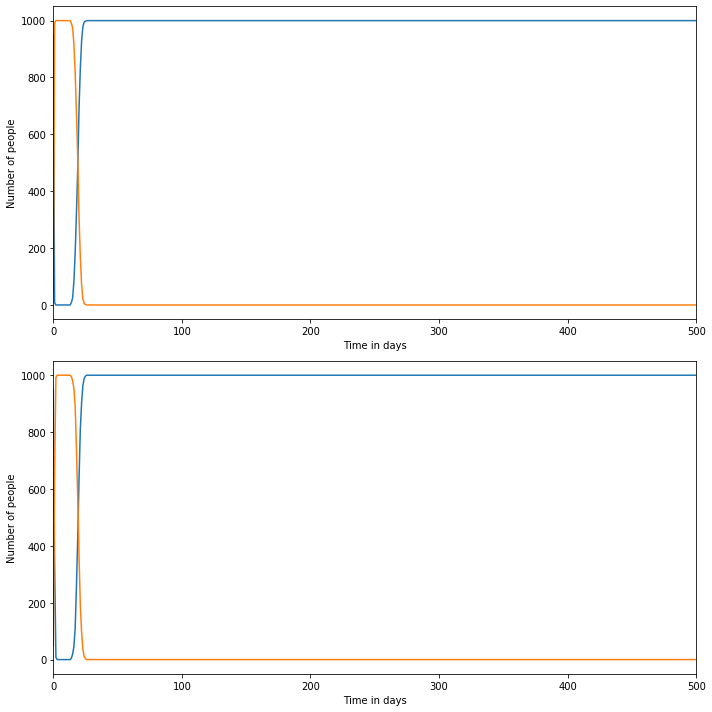

In [23]:
time_range = np.arange(0, time_limit+1, 1)
fig,ax = plt.subplots(len(scenarios),1,figsize=(10,10))
for i in range(len(scenarios)):
    ax[i].set_xlabel("Time in days")
    ax[i].set_ylabel("Number of people")
    ax[i].set_xlim(0,500)
    
    ax[i].fill_between(
        time_range,
        S_percent_2_5[i],
        S_percent_97_5[i],
        alpha=0.1
    )
    ax[i].fill_between(
        time_range,
        I_percent_2_5[i],
        I_percent_97_5[i],    
        alpha=0.1
    )
    ax[i].plot(
        time_range,
        np.mean(np.array(sim_S[:,i,:]),axis=0)
    )
    ax[i].plot(
        time_range,
        np.mean(np.array(sim_I[:,i,:]),axis=0)
    )
plt.tight_layout()

In [24]:
"""
base_S = []
for i in range(0,number_of_simulations):
    base_S.append(sim_S[i]["base"])
np.array(base_S).shape

base = []
for i in range(0,number_of_simulations):
    base.append(np.percentile(base_S[:][i],2.5))
"""
    
# EMIL: I get an error here    


    


'\nbase_S = []\nfor i in range(0,number_of_simulations):\n    base_S.append(sim_S[i]["base"])\nnp.array(base_S).shape\n\nbase = []\nfor i in range(0,number_of_simulations):\n    base.append(np.percentile(base_S[:][i],2.5))\n'

Both the suceptible and infectious are highly correlated maybe only plot one of both (todo)

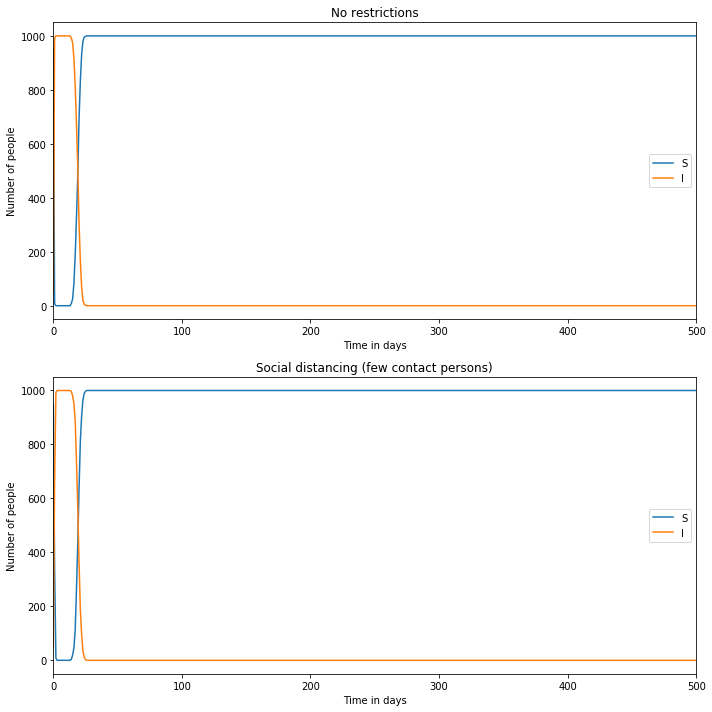

In [25]:
time_range = np.arange(0, time_limit+1, 1)
fig, ax = plt.subplots(len(scenarios),1,figsize=(10,10))

for i,key in enumerate(scenarios):
    ax[i].set_title(key)
    ax[i].set_xlabel("Time in days")
    ax[i].set_ylabel("Number of people")
    ax[i].set_xlim(0,500)
    ax[i].plot(time_range, S_t[key], label="S")
    ax[i].plot(time_range, I_t[key], label="I")
    ax[i].legend()
plt.tight_layout()